In [43]:
import numpy as np
from hyperopt import hp, fmin, tpe, space_eval
from scikits.odes.ode import ode
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import numpy as np
from hyperopt import hp, fmin, tpe, space_eval
from scikits.odes.ode import ode
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib
from GPyOpt.methods import BayesianOptimization
import GPyOpt

In [4]:
def loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-2):
        """Computes scalarized loss including genetic constraint and product production"""
        loss = alpha1*j1 + alpha2*j2
        return j1, j2, loss

def activation(x, k, theta, n):
    return (k*(x/theta)**n)/(1+(x/theta)**n)

def repression(x, k, theta, n):
    return k/(1+(x/theta)**n)
    
def nonlinearity(x, kc, km):
    return (kc*x)/(km+x)


In [5]:
def dual_control(t, y, ydot, p):
    n1, n2 = [2., 2.]
    kc=12.; km=10.; lam=1.93E-4; Vin=1.; e0=0.0467
    k1, k2, theta1, theta2 = p
    ydot[0] = Vin - lam*y[0] - e0*nonlinearity(y[0], kc, km) - y[2]*nonlinearity(y[0], kc, km)
    ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]
    ydot[2] = repression(y[1], k1, theta1, n1) - lam*y[2]
    ydot[3] = activation(y[1], k2, theta2, n2) - lam*y[3]
    ydot[4] = (Vin -  y[3]*nonlinearity(y[1], kc, km))**2
    ydot[5] = repression(y[1], k1, theta1, n1) + activation(y[1], k2, theta2, n2)

def upstream_repression(t, y, ydot, p):
    n1, n2 = [2., 2.]
    kc=12.; km=10.; lam=1.93E-4; Vin=1.; e0=0.0467
    k1, k2, theta1, theta2 = p
    ydot[0] = Vin - lam*y[0] - e0*nonlinearity(y[0], kc, km) - y[2]*nonlinearity(y[0], kc, km)
    ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]
    ydot[2] = repression(y[1], k1, theta1, n1) - lam*y[2]
    ydot[3] = k2 - lam*y[3]
    ydot[4] = (Vin -  y[3]*nonlinearity(y[1], kc, km))**2
    ydot[5] = repression(y[1], k1, theta1, n1) + k2

def downstream_activation(t, y, ydot, p):
    n1, n2 = [2., 2.]
    kc=12.; km=10.; lam=1.93E-4; Vin=1.; e0=0.0467
    k1, k2, theta1, theta2 = p
    ydot[0] = Vin - lam*y[0] - e0*nonlinearity(y[0], kc, km) - y[2]*nonlinearity(y[0], kc, km)
    ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]
    ydot[2] = k1 - lam*y[2]
    ydot[3] = activation(y[1], k2, theta2, n2) - lam*y[3]
    ydot[4] = (Vin -  y[3]*nonlinearity(y[1], kc, km))**2
    ydot[5] = activation(y[1], k2, theta2, n2) + k1

def no_control(t, y, ydot, p):
    n1, n2 = [2., 2.]
    kc=12.; km=10.; lam=1.93E-4; Vin=1.; e0=0.0467
    k1, k2, theta1, theta2 = p
    ydot[0] = Vin - lam*y[0] - e0*nonlinearity(y[0], kc, km) - y[2]*nonlinearity(y[0], kc, km)
    ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]
    ydot[2] = k1 - lam*y[2]
    ydot[3] = k2 - lam*y[3]
    ydot[4] = (Vin -  y[3]*nonlinearity(y[1], kc, km))**2
    ydot[5] = k1 + k2

In [6]:
space = hp.choice('architecture', 
    [([[0, 0, 1], [1, 0, 0]], [[2., hp.uniform('theta1_da', 0.001, 10), hp.uniform('k1_da', 1E-7, 1E-3)], [2., hp.uniform('theta2_da', 0.001, 10), hp.uniform('k2_da', 1E-7, 1E-3)]]),
     ([[0, 1, 0], [0, 0, 1]], [[2., hp.uniform('theta1_ur', 0.001, 10), hp.uniform('k1_ur', 1E-7, 1E-3)], [2., hp.uniform('theta2_ur', 0.001, 10), hp.uniform('k2_ur', 1E-7, 1E-3)]]),
     ([[0, 0, 1], [0, 0, 1]], [[2., hp.uniform('theta1_nc', 0.001, 10), hp.uniform('k1_nc', 1E-7, 1E-3)], [2., hp.uniform('theta2_nc', 0.001, 10), hp.uniform('k2_nc', 1E-7, 1E-3)]]),
     ([[0, 1, 0], [1, 0, 0]], [[2., hp.uniform('theta1_dc', 0.001, 10), hp.uniform('k1_dc', 1E-7, 1E-3)], [2., hp.uniform('theta2_dc', 0.001, 10), hp.uniform('k2_dc', 1E-7, 1E-3)]])])
    

In [7]:
def generated_equation(t, y, ydot, params):
    '''Generate function to solve with Scikit-ODEs'''
    kc=12.; km=10.; lam=1.93E-4; Vin=1.; e0=0.0467
    T = 1; E = 2; X = 2
    A, W = params
    ydot[0] = Vin - lam*y[0] - e0*nonlinearity(y[0], kc, km) - y[2]*nonlinearity(y[0], kc, km)
    ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]
    for e in range(E):
        ydot[e+X] = -lam*y[e+X] + np.sum(A[e]*np.array([activation(y[T], W[e][2], W[e][1], W[e][0]), repression(y[T], W[e][2], W[e][1], W[e][0]), W[e][2]]))
    ydot[E+X] = (Vin - y[X+1]*nonlinearity(y[X-1], kc, km))**2 #J1
    ydot[E+X+1] = np.sum([np.sum(A[e]*np.array([activation(y[T], W[e][2], W[e][1], W[e][0]), repression(y[T], W[e][2], W[e][1], W[e][0]), W[e][2]])) for e in range(E)]) #J2

In [8]:
losses = []
params = []
circuits = []
def objective(args):
    architecture, param_values = args
    #Integration conditions
    t = np.linspace(0, 5E4, 100) 
    y0 = np.array([2290., 0., 0., 0., 0., 0.])

    extra_options = {'old_api': False, 'user_data': [architecture, param_values]}
    ode_solver = ode('cvode', generated_equation, **extra_options)
    solution = ode_solver.solve(t, y0)
    j1, j2 = solution.values.y[-1, -2:]
    j1, j2, loss = loss_biological(j1, j2)

    losses.append(loss)
    params.append(param_values)
    circuits.append(architecture)
    return loss
    

In [9]:
best = fmin(objective, space, algo=tpe.suggest, max_evals=1000)
space_eval(space, best)

100%|██████████| 1000/1000 [00:55<00:00, 17.91trial/s, best loss: 0.06361829330103425]


(((0, 1, 0), (1, 0, 0)),
 ((2.0, 2.825770750141905, 0.0008760875262226193),
  (2.0, 9.991988954927479, 4.7759329491797996e-05)))

In [134]:
landscape = pd.DataFrame({'circuit':circuits, 'loss': losses, 'k1': [params[i][0][2] for i in range(len(params))], 'k2': [params[i][1][2] for i in range(len(params))], 'theta1': [params[i][0][1] for i in range(len(params))], 'theta2': [params[i][1][1] for i in range(len(params))]})
landscape['Circuit'] = [name_converter(c) for c in landscape.circuit]

In [135]:
features = ['k1', 'k2', 'theta1', 'theta2']

x = landscape.loc[:, features].values

#Normalize features
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2'])
landscape['pc1'] = principalComponents[:,0]
landscape['pc2'] = principalComponents[:,1]


tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, init='pca')
tsne_results = tsne.fit_transform(x)
landscape['tsne1'] = tsne_results[:,0]
landscape['tsne2'] = tsne_results[:,1]

/Users/charlotte/opt/anaconda3/envs/sundials/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/charlotte/opt/anaconda3/envs/sundials/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2769 samples in 0.002s...
[t-SNE] Computed neighbors for 2769 samples in 0.083s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2769
[t-SNE] Computed conditional probabilities for sample 2000 / 2769
[t-SNE] Computed conditional probabilities for sample 2769 / 2769
[t-SNE] Mean sigma: 0.267396
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.798996
[t-SNE] KL divergence after 300 iterations: 1.492060


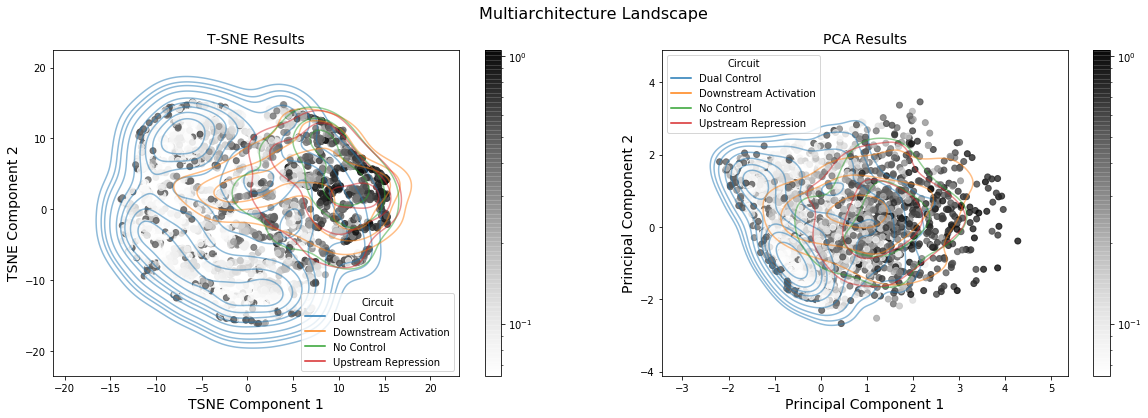

In [138]:
import matplotlib
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

endpoint = 'T-SNE Results'
ax = axs[0]
sns.kdeplot(
    data=landscape,
    x="tsne1",
    y="tsne2",
    hue='Circuit',
    thresh=.1, ax=ax, alpha=0.5
)
contour = ax.scatter(data=landscape, x="tsne1", y="tsne2", alpha = .8, c = 'loss', cmap = 'Greys', norm=matplotlib.colors.LogNorm())
fig.colorbar(contour, ax=ax)
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('TSNE Component 1', fontsize=14)
ax.set_ylabel('TSNE Component 2', fontsize=14)


endpoint = 'PCA Results'
ax = axs[1]
contour = ax.scatter(data=landscape, x="pc1", y="pc2", alpha = .8, c = 'loss', cmap = 'Greys', norm=matplotlib.colors.LogNorm())
fig.colorbar(contour, ax=ax)
sns.kdeplot(
    data=landscape,
    x="pc1",
    y="pc2",
    hue='Circuit',
    thresh=.1, ax=ax, alpha=0.5
)
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('Principal Component 1', fontsize=14)
ax.set_ylabel('Principal Component 2', fontsize=14)
fig.suptitle('Multiarchitecture Landscape', fontsize=16)
fig.savefig('multiarchitecture_generated.png')

In [59]:
def name_converter(A):
    if A == ((0, 1, 0), (1, 0, 0)):
        return 'Dual Control'

    elif A == ((0, 0, 1), (0, 0, 1)):
        return 'No Control'

    elif A == ((0, 0, 1), (1, 0, 0)):
        return 'Downstream Activation'

    elif A == ((0, 1, 0), (0, 0, 1)):
        return 'Upstream Repression'
    else: return 'Invalid Circuit'

In [60]:
def arch_converter(a):
    if a == 1:
        return (0, 1, 0)
    elif a == 0:
        return (1, 0, 0)
    else: 
        return (0, 0, 1)

In [80]:
losses = []
circuits = []
def objective(args):
    #Integration conditions
    t = np.linspace(0, 5E4, 100) 
    y0 = np.array([2290., 0., 0., 0., 0., 0.])

    architecture = [arch_converter(args[:, 0]), arch_converter(args[:, 1])]
    param_values = [[2., args[:, 4], args[:, 2]], [2., args[:, 5], args[:, 3]]]
    extra_options = {'old_api': False, 'user_data': [architecture, param_values]}
    ode_solver = ode('cvode', generated_equation, **extra_options)
    solution = ode_solver.solve(t, y0)
    j1, j2 = solution.values.y[-1, -2:]
    j1, j2, loss = loss_biological(j1, j2)

    losses.append(loss)
    circuits.append(architecture)
    return loss

In [81]:
#Domain allowing all possible architectures
domain = [{'name': 'e1_arch', 'type': 'discrete', 'domain': (0, 1, 2)}, {'name': 'e2_arch', 'type': 'discrete', 'domain': (0, 1, 2)} 
,{'name': 'k1', 'type': 'continuous', 'domain': (1E-7,1E-3)}, {'name': 'k2', 'type': 'continuous', 'domain': (1E-7,1E-3)}, 
        {'name': 'theta1', 'type': 'continuous', 'domain': (0.001,10)}, {'name': 'theta2', 'type': 'continuous', 'domain': (0.001,10)}]
maxiter = 500

In [82]:
#Domain allowing only 4 architectures of interest
domain = [{'name': 'e1_arch', 'type': 'discrete', 'domain': (1, 2)}, {'name': 'e2_arch', 'type': 'discrete', 'domain': (0, 2)} 
,{'name': 'k1', 'type': 'continuous', 'domain': (1E-7,1E-3)}, {'name': 'k2', 'type': 'continuous', 'domain': (1E-7,1E-3)}, 
        {'name': 'theta1', 'type': 'continuous', 'domain': (0.001,10)}, {'name': 'theta2', 'type': 'continuous', 'domain': (0.001,10)}]
maxiter = 300

In [83]:
myBopt_2d = BayesianOptimization(objective, domain=domain)
myBopt_2d.run_optimization(max_iter = maxiter)
print("="*20)
print("Value of (x,y) that minimises the objective:"+str(myBopt_2d.x_opt))    
print("Minimum value of the objective: "+str(myBopt_2d.fx_opt))     
print("="*20)

Value of (x,y) that minimises the objective:[1.00000000e+00 2.00000000e+00 5.24653191e-06 4.48563542e-06
 7.74899815e+00 3.11260794e+00]
Minimum value of the objective: 0.15838699002659778


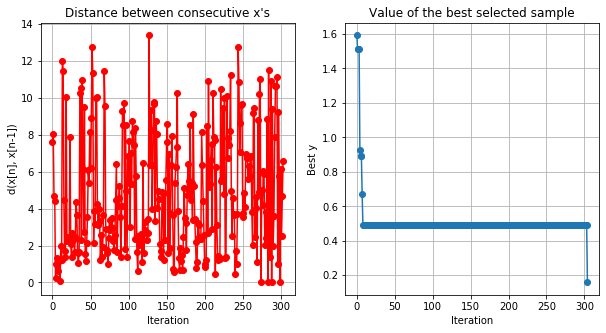

In [84]:
myBopt_2d.plot_convergence()

In [85]:
ins = myBopt_2d.get_evaluations()[0]
k1s = ins[:, 0]
k2s = ins[:, 1]
theta1s = ins[:, 2]
theta2s = ins[:, 3]
losses = myBopt_2d.get_evaluations()[1].flatten()
evals = pd.DataFrame({'circuits': circuits[-305:],'k1':k1s, 'k2':k2s, 'theta1':theta1s, 'theta2':theta2s, 'loss':losses})

In [86]:
def name_converter(A):
    if A == '[(0, 1, 0), (1, 0, 0)]':
        return 'Dual Control'

    elif A == '[(0, 0, 1), (0, 0, 1)]':
        return 'No Control'

    elif A == '[(0, 0, 1), (1, 0, 0)]':
        return 'Downstream Activation'

    elif A == '[(0, 1, 0), (0, 0, 1)]':
        return 'Upstream Repression'
    else: return 'Invalid Circuit'
    
evals['circuits'] = [str(evals.circuits[i]) for i in range(len(evals))]
evals['Circuit'] = [name_converter(evals.circuits[i]) for i in range(len(evals))]

In [87]:
evals.to_csv('300_restricted_multiarch_2.csv')

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 305 samples in 0.001s...
[t-SNE] Computed neighbors for 305 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 305 / 305
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 38.083710
[t-SNE] KL divergence after 300 iterations: -0.865613


Text(0.5, 0.98, 'Multiarchitecture Landscape')

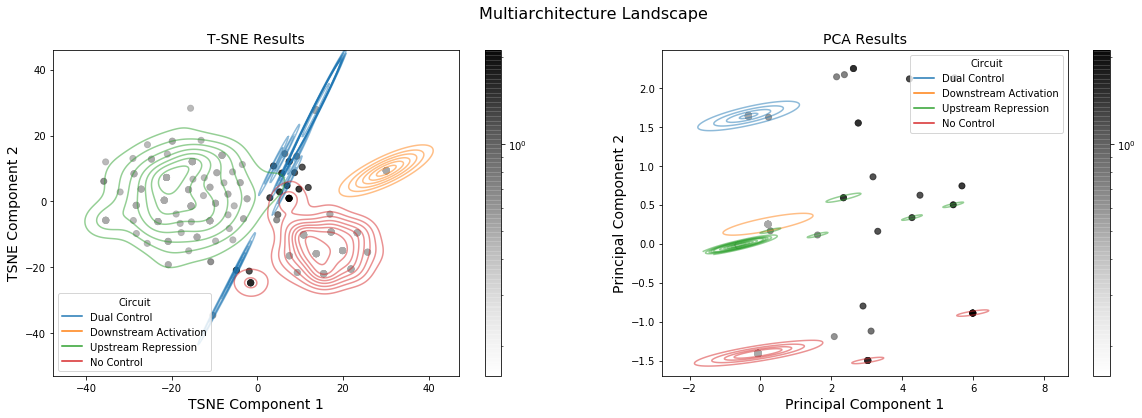

In [88]:
features = ['k1', 'k2', 'theta1', 'theta2']
landscape = evals
x = landscape.loc[:, features].values

#Normalize features
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2'])
landscape['pc1'] = principalComponents[:,0]
landscape['pc2'] = principalComponents[:,1]


tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, init='pca')
tsne_results = tsne.fit_transform(x)
landscape['tsne1'] = tsne_results[:,0]
landscape['tsne2'] = tsne_results[:,1]

fig, axs = plt.subplots(1, 2, figsize=(20, 6))

endpoint = 'T-SNE Results'
ax = axs[0]
sns.kdeplot(
    data=landscape,
    x="tsne1",
    y="tsne2",
    hue='Circuit',
    thresh=.1, ax=ax, alpha=0.5
)
contour = ax.scatter(data=landscape, x="tsne1", y="tsne2", alpha = .8, c = 'loss', cmap = 'Greys', norm=matplotlib.colors.LogNorm())
fig.colorbar(contour, ax=ax)
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('TSNE Component 1', fontsize=14)
ax.set_ylabel('TSNE Component 2', fontsize=14)


endpoint = 'PCA Results'
ax = axs[1]
contour = ax.scatter(data=landscape, x="pc1", y="pc2", alpha = .8, c = 'loss', cmap = 'Greys', norm=matplotlib.colors.LogNorm())
fig.colorbar(contour, ax=ax)
sns.kdeplot(
    data=landscape,
    x="pc1",
    y="pc2",
    hue='Circuit',
    thresh=.1, ax=ax, alpha=0.5
)
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('Principal Component 1', fontsize=14)
ax.set_ylabel('Principal Component 2', fontsize=14)
fig.suptitle('Multiarchitecture Landscape', fontsize=16)


Text(0.5, 0.98, 'Multiarchitecture Landscape')

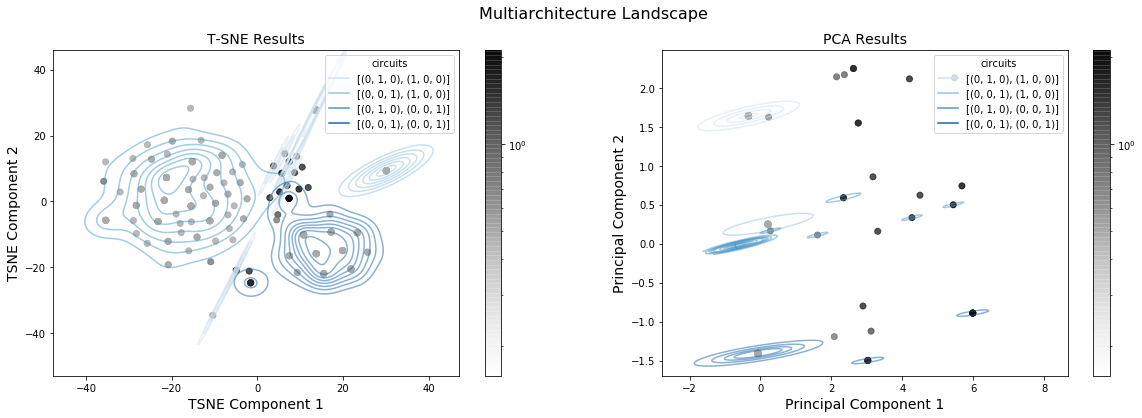

In [89]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

endpoint = 'T-SNE Results'
ax = axs[0]
sns.kdeplot(
    data=landscape,
    x="tsne1",
    y="tsne2",
    hue='circuits',palette='Blues',
    thresh=.1, ax=ax, alpha=0.5
)
contour = ax.scatter(data=landscape, x="tsne1", y="tsne2", alpha = .8, c = 'loss', cmap = 'Greys', norm=matplotlib.colors.LogNorm())
fig.colorbar(contour, ax=ax)
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('TSNE Component 1', fontsize=14)
ax.set_ylabel('TSNE Component 2', fontsize=14)


endpoint = 'PCA Results'
ax = axs[1]
contour = ax.scatter(data=landscape, x="pc1", y="pc2", alpha = .8, c = 'loss', cmap = 'Greys', norm=matplotlib.colors.LogNorm())
fig.colorbar(contour, ax=ax)
sns.kdeplot(
    data=landscape,
    x="pc1",
    y="pc2",
    hue='circuits', palette='Blues',
    thresh=.1, ax=ax, alpha=0.5
)
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('Principal Component 1', fontsize=14)
ax.set_ylabel('Principal Component 2', fontsize=14)
fig.suptitle('Multiarchitecture Landscape', fontsize=16)

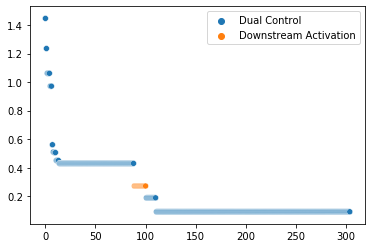

In [91]:
evals = pd.read_csv('300_restricted_multiarch.csv')
best_loss = 1000
best_circuit = 'Initial'
best_losses = []
best_losses_circuits = []
for i in range(len(evals)):
    if evals.loss[i] < best_loss:
        best_loss = evals.loss[i]
        best_circuit = evals.Circuit[i]
    best_losses.append(best_loss)
    best_losses_circuits.append(best_circuit)

sns.scatterplot(range(len(evals)), best_losses, hue=best_losses_circuits)